In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
def pipeline(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, ['Age_categories','Fare_categories','Title','Cabin_type','Sex'])
    return df

In [5]:
train = pipeline(train)
holdout = pipeline(holdout)

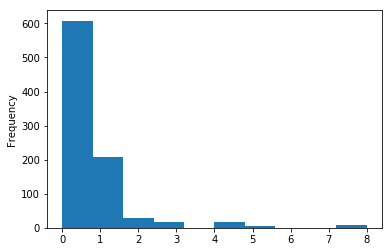

In [6]:
train.SibSp.plot.hist();

In [7]:
train.pivot_table('Survived','SibSp')

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


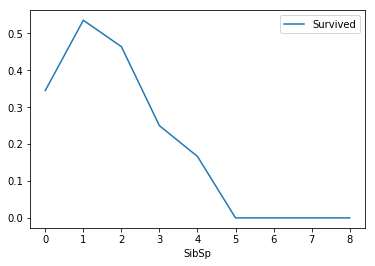

In [8]:
train.pivot_table('Survived','SibSp').plot.line();

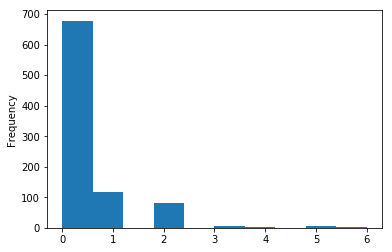

In [9]:
train.Parch.plot.hist();

In [10]:
train.pivot_table('Survived','Parch')

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


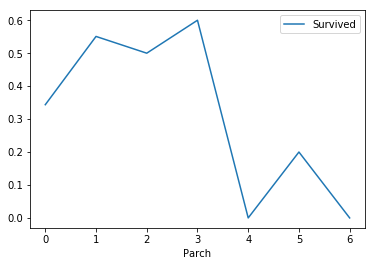

In [11]:
train.pivot_table('Survived','Parch').plot.line();

both SibSp and Parch features are positively skewed. Surprisingly, there seems to be a negative correlation between survival rate and number of family members onboard for both of these features, although the correlation is more pronounced in the SibSp distribution. Also, those with no family members have lower rates of survival, intuitively.

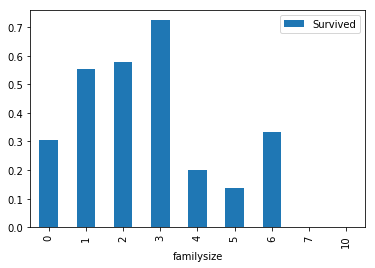

In [12]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index='familysize',values="Survived")
pivot.plot.bar();

In [13]:
def add_isalone(df):
    a = pd.Series()
    a = df.SibSp + df.Parch
    df['isalone'] = a.apply(lambda x: 1 if (x == 0) else 0)
    return df

In [14]:
train = add_isalone(train)
holdout = add_isalone(holdout)

In [15]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from pandas.api.types import is_numeric_dtype

/Users/steve/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [16]:
def select_features(df):
    df = df.dropna(axis=1)
    mask = []
    for col in df.dtypes.index:
        mask.append(is_numeric_dtype(df[col]))
    new_cols = df.dtypes[mask].index
    df = df[new_cols]
    all_X = df.drop(columns=['PassengerId','Survived'])
    all_y = df['Survived']
    rfc = RandomForestClassifier()
    selector = RFECV(rfc, cv=10)
    selector.fit(all_X, all_y)
    best_feats = all_X.columns[selector.support_]
    return best_feats

In [17]:
best_feats = select_features(train)
best_feats.shape

(31,)

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [19]:
def select_model(df, feats):
    all_X = df[feats]
    all_y = df.Survived
    lod = [
        {
            'name':'LogisticRegression',
            'estimator': LogisticRegression(),
            'hyperparameters': {
                'solver':['newton-cg','lbfgs','liblinear']
            }
        },
        {
            'name':'KNeighborsClassifier',
            'estimator': KNeighborsClassifier(),
            'hyperparameters': {
                'n_neighbors': range(1,20,2),
                'weights': ['distance', 'uniform'],
                'algorithm': ['ball_tree','kd_tree','brute'],
                'p':[1,2]
            }
        },
        {
            'name':'RandomForestClassifier',
            'estimator': RandomForestClassifier(),
            'hyperparameters': {
                'n_estimators': [4,6,9],
                'criterion': ['entropy','gini'],
                'max_depth': [2,5,10],
                'max_features': ['log2','sqrt'],
                'min_samples_leaf': [1,5,8],
                'min_samples_split': [2,3,5]
            }
        }
    ]
    for d in lod:
        print(d['name'])
        gs = GridSearchCV(d['estimator'], d['hyperparameters'], cv=10)
        gs.fit(all_X, all_y)
        d['best_params'] = gs.best_params_
        d['best_score'] = gs.best_score_
        d['best_estimator'] = gs.best_estimator_
        print(d['best_params'])
        print(d['best_score'])
    return lod    

In [20]:
lod = select_model(train, best_feats)
lod;

LogisticRegression
{'solver': 'newton-cg'}
0.819304152637486
KNeighborsClassifier
{'algorithm': 'kd_tree', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.77665544332211
RandomForestClassifier
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 4}
0.8383838383838383


In [21]:
def save_submission_file(model, cols, filename='submission.csv'):
    preds = model.predict(holdout[cols])
    sub_df = pd.DataFrame({'PassengerId':holdout.PassengerId,'Survived':preds})
    sub_df.to_csv(filename, index=False)

In [22]:
lod[2]['best_estimator']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
save_submission_file(lod[2]['best_estimator'], best_feats)

# submission 1
## rank: 7610, accuracy: 0.76555